In [42]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime, timedelta
from collections import defaultdict
from multiprocessing import Manager

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "7g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .appName('exploration') \
    .getOrCreate()

24/09/16 19:27:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
tbl_merchants = spark.read.parquet('../data/curated/tbl_merchants')
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "\\s+", " "))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", except appliances", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "rent al", "rental"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ":", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " -", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " shops", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " services", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " service", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " and", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", sales", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " ,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",]", "]"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\[", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\]", ""))

tbl_merchants.show(truncate=False)

+------------------------------------+-----------------------------------------------------------------------------------------------------------------+------------+----------------------------------------------------------------+-----+-----+
|merchant_name                       |tags                                                                                                             |merchant_abn|tags1                                                           |tags2|tags3|
+------------------------------------+-----------------------------------------------------------------------------------------------------------------+------------+----------------------------------------------------------------+-----+-----+
|Felis Limited                       |[[furniture, home furnishings and equipment shops, and manufacturers, except appliances], [e], [take rate: 0.18]]|10023283211 |furniture, home furnishings, equipment, manufacturers           |e    |0.18 |
|Arcu Ac Orci Corporation   

In [3]:
transactions = spark.read.parquet("../data/curated/full_transaction")
transactions.show()

+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+--------+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+
|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|    consumer_name|state|postcode|     gender|fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|
+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+--------+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+
|    2021-11-26| 79417999332|  14935|    1059280|136.06570809815838|23acbb7b-cf98-458...|    Cameron Adams|  QLD|    4563|       Male|             NULL|Phasellus At Company|[[gift, card, nov...|gift, card, novel...|    b| 4.95|        

In [212]:
merchant_fraud = spark.read.option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud.groupBy("merchant_abn").count().show()

+------------+-----+
|merchant_abn|count|
+------------+-----+
| 67264251405|    1|
| 43083074133|    1|
| 99989036621|    1|
| 31334588839|   12|
| 11590404675|    1|
| 29674997261|    1|
| 14827550074|    4|
| 83220249221|    1|
| 76767266140|    1|
| 59258669983|    1|
| 94493496784|    1|
| 80089686333|    1|
| 35909341340|    1|
| 19492220327|    8|
| 18737319630|    1|
| 11149063370|    3|
| 57564805948|    1|
| 21439773999|    1|
| 18158387243|    2|
| 82999039227|    1|
+------------+-----+
only showing top 20 rows



In [6]:
merchant_fraud = merchant_fraud.withColumn("fraud_probability", F.col("fraud_probability").cast(DoubleType()))
merchant_fraud.select("merchant_abn", "fraud_probability").groupBy("merchant_abn") \
    .agg(
        F.count("*").alias("count"),
        F.mean("fraud_probability").alias("mean_fraud_probability")
    ).show(1000)

+------------+-----+----------------------+
|merchant_abn|count|mean_fraud_probability|
+------------+-----+----------------------+
| 67264251405|    1|     18.21089142894488|
| 43083074133|    1|     48.66890735193894|
| 99989036621|    1|     18.21089142894488|
| 31334588839|   12|     32.36111871776698|
| 11590404675|    1|    29.607818240092094|
| 29674997261|    1|     44.43787807900268|
| 14827550074|    4|     42.00056688395546|
| 83220249221|    1|     63.51245947057463|
| 76767266140|    1|    29.539733207182703|
| 59258669983|    1|    30.180090258715534|
| 94493496784|    1|     30.57903215900633|
| 80089686333|    1|      67.5058112247036|
| 35909341340|    1|     29.13305311007307|
| 19492220327|    8|    31.958306675667547|
| 18737319630|    1|     72.73069736562613|
| 11149063370|    3|     53.28693336242285|
| 57564805948|    1|    31.268145098828853|
| 21439773999|    1|    28.504479048104585|
| 18158387243|    2|     29.02968340431819|
| 82999039227|    1|      94.134

In [46]:
fraud_transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).to_pandas_on_spark()
fraud_transactions.plot.scatter('dollar_value', 'merchant_fraud_probability')

/Users/alanlu/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/documents/2024/MAST30034/proj2/.venv/lib/python3.11/site-packages/pyspark/sql/dataframe.py:5725: FutureWarning:

DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.



<Axes: xlabel='dollar_value', ylabel='merchant_fraud_probability'>

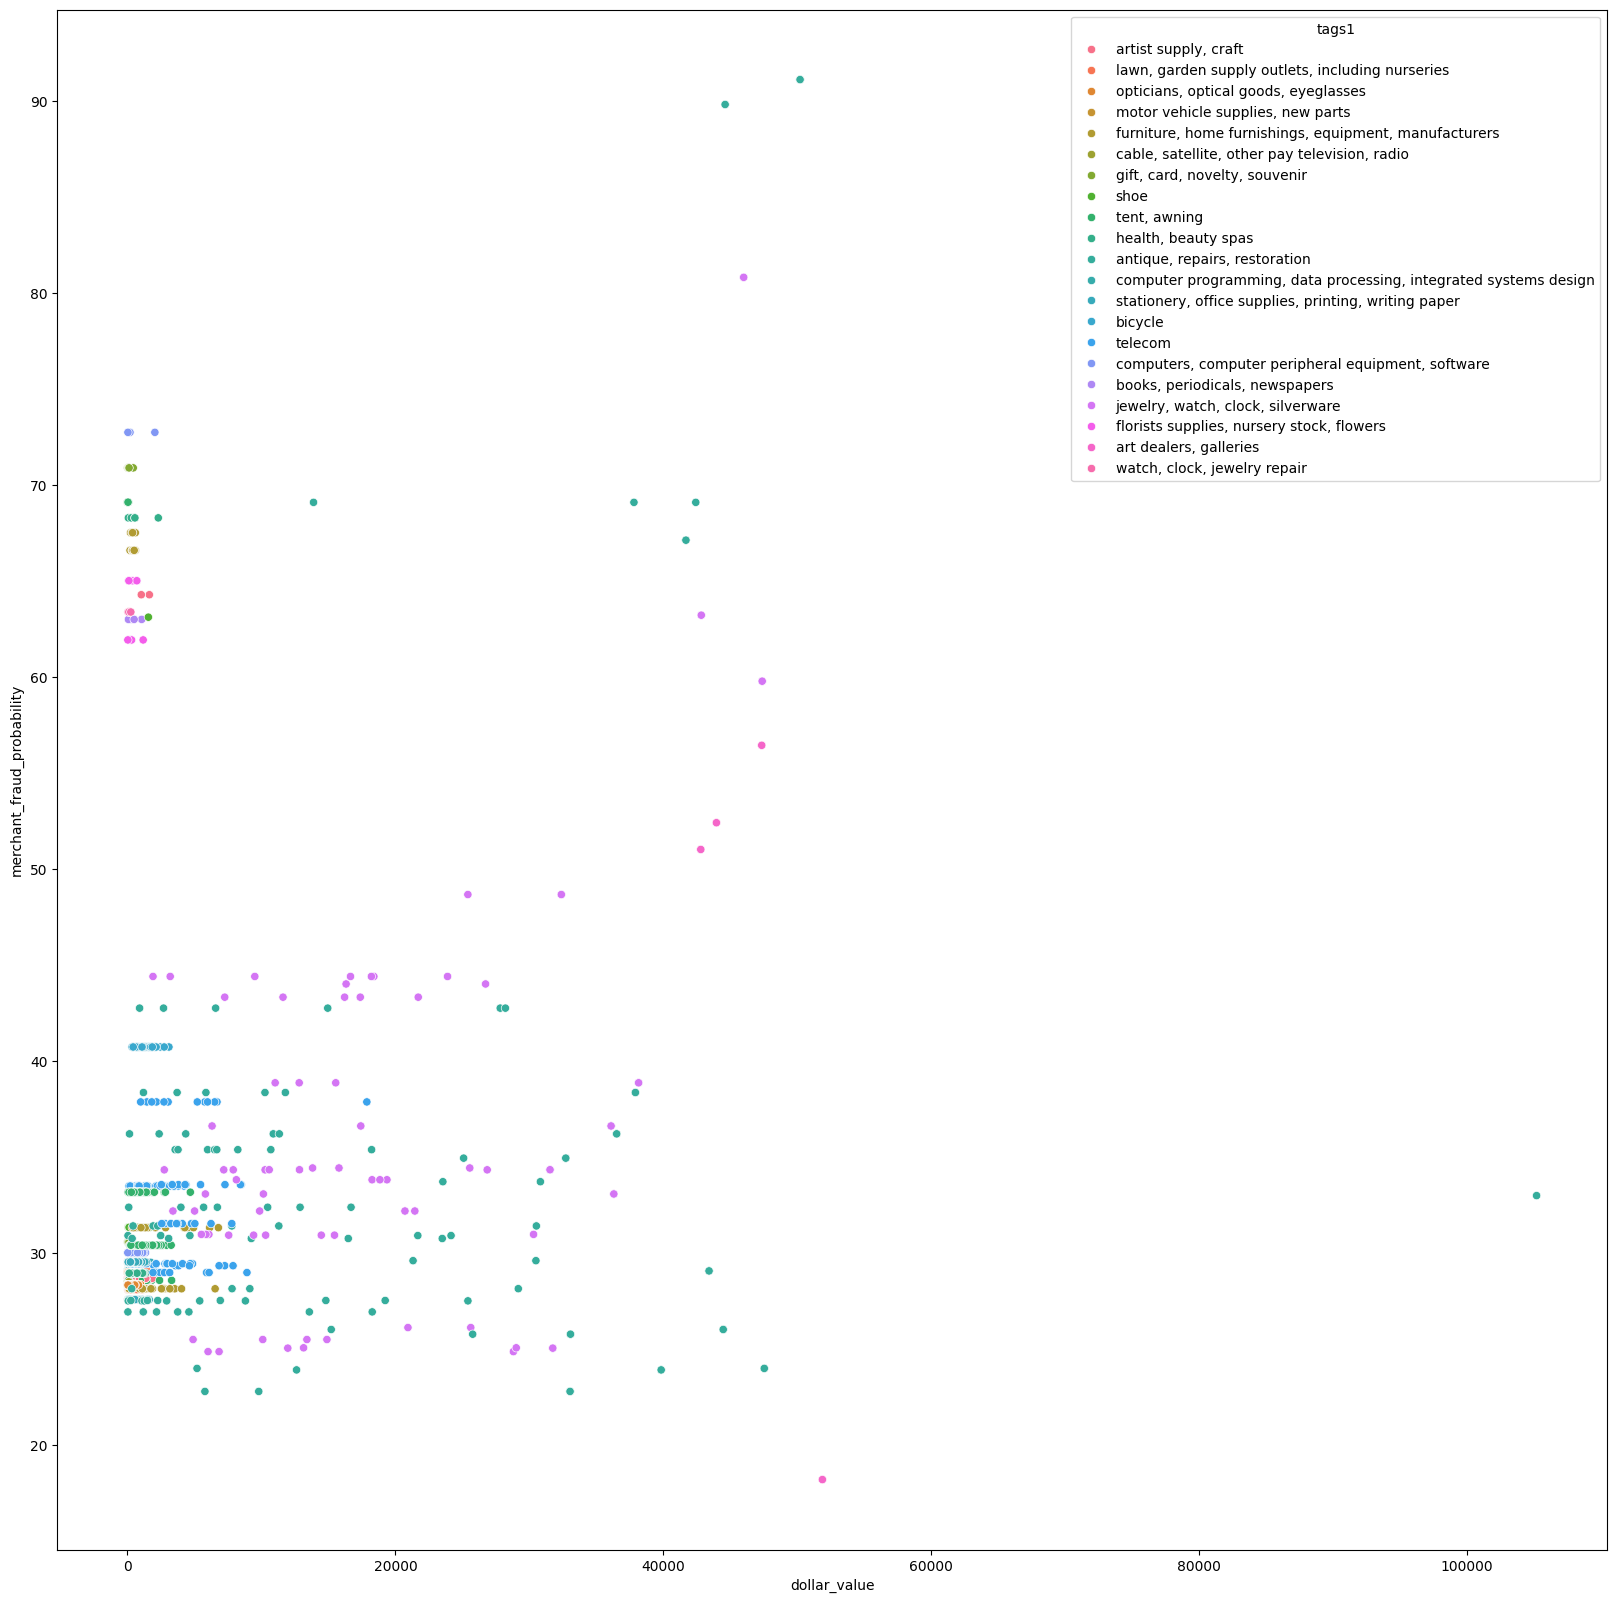

In [61]:
fraud_transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()
plt.figure(figsize=(20, 20))
sns.scatterplot(fraud_transactions, x='dollar_value', y='merchant_fraud_probability', hue='tags1')

# Impute merchant fraud probabilities

RMSE: 2.3230162473554574


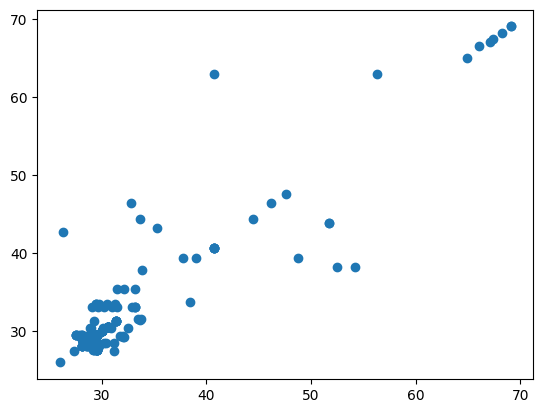

In [222]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

fraud_transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()
categories = transactions.select('tags1').distinct().toPandas().dropna().astype("string")['tags1'].to_list()

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [13]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [7]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [4]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [15]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=3, weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

X = fraud_transactions.drop('merchant_fraud_probability', axis=1)
y = fraud_transactions['merchant_fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

pipeline.fit(X_train, y_train)

#
plt.scatter(pipeline.predict(X_test), y_test)
print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

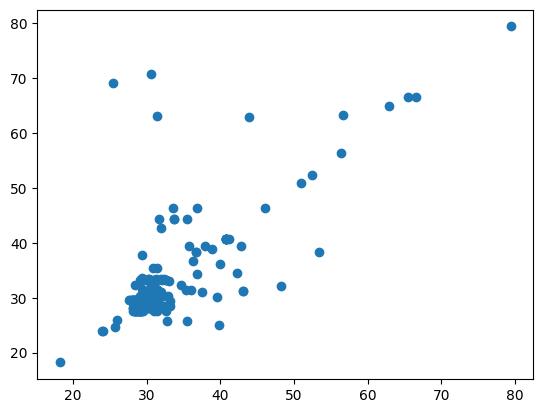

In [105]:
len(preprocessor.fit_transform(fraud_transactions))
# np.argwhere(np.isnan(preprocessor.fit_transform(fraud_transactions)))

35

In [ ]:
from kmodes.kprototypes import KPrototypes
fraud_transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()
fraud_transactions = fraud_transactions.loc[:, ['dollar_value', 'tags1']]
kproto = KPrototypes(n_clusters=4, init='Cao', verbose=2)
clusters = kproto.fit_predict(X, categorical=[1, 2])

# Print cluster centroids of the trained model.
print(kproto.cluster_centroids_)
# Print training statistics
print(kproto.cost_)
print(kproto.n_iter_)

for s, c in zip(syms, clusters):
    print(f"Symbol: {s}, cluster:{c}")

In [95]:
fraud_transactions

,order_datetime,merchant_abn,user_id,consumer_id,dollar_value,order_id,consumer_name,state,postcode,gender,fraud_probability,merchant_name,tags,tags1,tags2,tags3,merchant_fraud_probability
0,2021-11-26,39649557865,14938,267457,209.127810,4d78cd01-4bab-494f-97cf-f7443faa348b,Jasmine Ford,NSW,2625.0,Undisclosed,NaN,Arcu Morbi Institute,"[[artist supply and craft shops], [c], [take rate: 1.47]]","artist supply, craft",c,1.47,28.690204
1,2021-11-26,50315283629,14939,764252,575.332107,026c6d3d-4f7c-4f4a-aacd-39768c24975c,Cassandra Myers,VIC,3885.0,Female,NaN,Iaculis Aliquet Diam LLC,"[[lawn and garden supply outlets, including nurseries], [c], [take rate: 1.76]]","lawn, garden supply outlets, including nurseries",c,1.76,29.088158
2,2021-11-26,48534649627,15,1463076,20.288326,077102ea-326f-4987-b82a-ac1f5705e8e1,Paul Abbott,QLD,4512.0,Male,NaN,Dignissim Maecenas Foundation,"[[opticians, optical goods, and eyeglasses], [a], [take rate: 6.64]]","opticians, optical goods, eyeglasses",a,6.64,29.005907
3,2021-11-26,96680767841,15,1463076,376.698537,035952ac-0551-4ffb-ba43-11c477fe126e,Paul Abbott,QLD,4512.0,Male,NaN,Ornare Limited,"[[motor vehicle supplies and new parts], [a], [take rate: 5.91]]","motor vehicle supplies, new parts",a,5.91,29.555245
4,2021-11-26,76767266140,17,1331093,193.802993,95330094-01e5-487d-b6ef-82a8d55e5eb5,Alyssa Wilson,VIC,3719.0,Female,NaN,Phasellus At Limited,"[[furniture, home furnishings and equipment shops, and manufacturers, except appliances], [b], [take rate: 4.65]]","furniture, home furnishings, equipment, manufacturers",b,4.65,29.539733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4089,2022-01-27,90918180829,19789,1062095,36306.334673,df1bcb3c-fcca-44cb-9063-5cd23e7699bf,Devin Gibson,WA,6332.0,Male,72.740291,Pharetra Quisque Company,"[[jewelry, watch, clock, and silverware shops], [c], [take rate: 2.62]]","jewelry, watch, clock, silverware",c,2.62,33.080273
4090,2022-01-27,90918180829,22857,207719,5813.483892,cb44a4bd-e821-452c-be07-ee09341f50d5,Daniel Adams,WA,6054.0,Male,20.120026,Pharetra Quisque Company,"[[jewelry, watch, clock, and silverware shops], [c], [take rate: 2.62]]","jewelry, watch, clock, silverware",c,2.62,33.080273
4091,2022-01-04,83199298021,5554,1410296,39840.204187,8e4a2819-867e-4750-935b-7cb551690ce5,Krystal Brennan,NSW,2354.0,Undisclosed,73.741133,Ligula Elit Pretium Foundation,"[[antique shops - sales, repairs, and restoration services], [b], [take rate: 4.82]]","antique, repairs, restoration",b,4.82,23.920306
4092,2022-01-04,83199298021,5554,1410296,39840.204187,8e4a2819-867e-4750-935b-7cb551690ce5,Krystal Brennan,NSW,2354.0,Undisclosed,73.741133,Ligula Elit Pretium Foundation,"[[antique shops - sales, repairs, and restoration services], [b], [take rate: 4.82]]","antique, repairs, restoration",b,4.82,23.920306


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from scipy.special import logit

fraud_transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()

x = fraud_transactions.loc[:, ['dollar_value']]
y = logit(fraud_transactions.loc[:, ['merchant_fraud_probability']] / 100.0)
log_reg = LinearRegression()
log_reg.fit(x, y)
y_pred = log_reg.predict(x)

root_mean_squared_error(y, y_pred)

0.2654551285720666

,order_datetime,merchant_abn,user_id,consumer_id,dollar_value,order_id,consumer_name,state,postcode,gender,fraud_probability,merchant_name,tags,tags1,tags2,tags3,merchant_fraud_probability
0,2021-11-26,39649557865,14938,267457,209.127810,4d78cd01-4bab-494f-97cf-f7443faa348b,Jasmine Ford,NSW,2625.0,Undisclosed,NaN,Arcu Morbi Institute,"[[artist supply and craft shops], [c], [take r...","artist supply, craft",c,1.47,28.690204
1,2021-11-26,50315283629,14939,764252,575.332107,026c6d3d-4f7c-4f4a-aacd-39768c24975c,Cassandra Myers,VIC,3885.0,Female,NaN,Iaculis Aliquet Diam LLC,"[[lawn and garden supply outlets, including nu...","lawn, garden supply outlets, including nurseries",c,1.76,29.088158
2,2021-11-26,48534649627,15,1463076,20.288326,077102ea-326f-4987-b82a-ac1f5705e8e1,Paul Abbott,QLD,4512.0,Male,NaN,Dignissim Maecenas Foundation,"[[opticians, optical goods, and eyeglasses], [...","opticians, optical goods, eyeglasses",a,6.64,29.005907
3,2021-11-26,96680767841,15,1463076,376.698537,035952ac-0551-4ffb-ba43-11c477fe126e,Paul Abbott,QLD,4512.0,Male,NaN,Ornare Limited,"[[motor vehicle supplies and new parts], [a], ...","motor vehicle supplies, new parts",a,5.91,29.555245
4,2021-11-26,76767266140,17,1331093,193.802993,95330094-01e5-487d-b6ef-82a8d55e5eb5,Alyssa Wilson,VIC,3719.0,Female,NaN,Phasellus At Limited,"[[furniture, home furnishings and equipment sh...","furniture, home furnishings, equipment, manufa...",b,4.65,29.539733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4089,2022-01-27,90918180829,19789,1062095,36306.334673,df1bcb3c-fcca-44cb-9063-5cd23e7699bf,Devin Gibson,WA,6332.0,Male,72.740291,Pharetra Quisque Company,"[[jewelry, watch, clock, and silverware shops]...","jewelry, watch, clock, silverware",c,2.62,33.080273
4090,2022-01-27,90918180829,22857,207719,5813.483892,cb44a4bd-e821-452c-be07-ee09341f50d5,Daniel Adams,WA,6054.0,Male,20.120026,Pharetra Quisque Company,"[[jewelry, watch, clock, and silverware shops]...","jewelry, watch, clock, silverware",c,2.62,33.080273
4091,2022-01-04,83199298021,5554,1410296,39840.204187,8e4a2819-867e-4750-935b-7cb551690ce5,Krystal Brennan,NSW,2354.0,Undisclosed,73.741133,Ligula Elit Pretium Foundation,"[[antique shops - sales, repairs, and restorat...","antique, repairs, restoration",b,4.82,23.920306
4092,2022-01-04,83199298021,5554,1410296,39840.204187,8e4a2819-867e-4750-935b-7cb551690ce5,Krystal Brennan,NSW,2354.0,Undisclosed,73.741133,Ligula Elit Pretium Foundation,"[[antique shops - sales, repairs, and restorat...","antique, repairs, restoration",b,4.82,23.920306


In [34]:
y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])